<a href="https://colab.research.google.com/github/robLaing2/Forex_ANN_Forecasting/blob/master/ForexAnnEnvironment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up Environment

In [2]:
%tensorflow_version 2.x

!pip install quandl
!pip install dbnomics
#!pip install FRB
!pip install fred
!pip install mock
#!pip uninstall tensorflow
#!pip install tensorflow==2.0.0

import fred
from mock import Mock
import requests
import json
import quandl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, CuDNNLSTM
from dbnomics import fetch_series
import pandas as pd
from keras.models import model_from_json
import matplotlib as mpl
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Data Preparation

In [3]:
START_DATE = '2001-01-01'
END_DATE = '2020-02-01'

pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


## Moving average function

In [0]:
def getMovingAverages(data, windowSize):

    movingAverages = []

    for x in range(len(data)):
        if (x < windowSize):
            window = data[:x+1]
        else:
            window = data[x-(windowSize - 1):x+1]
        
        total = sum(window)
        average = total / len(window)
        movingAverages.append(average)

    return movingAverages

## FOREX data

In [5]:
# Get FOREX data
quandl.ApiConfig.api_key = "VXqfuyrbTE8xxYZzqePw"
dataGbpEurRate = quandl.get("BOE/XUDLERS", start_date=START_DATE, end_date=END_DATE, returns="numpy")
forexDataN = dataGbpEurRate.Value

forexMonthMovAvg = getMovingAverages(forexDataN, 22)
forexMonthMovAvg = np.asarray(forexMonthMovAvg)

# Normalise data
forex_mean = forexMonthMovAvg.mean()
forex_std = forexMonthMovAvg.std()
forexMonthMovAvg = (forexMonthMovAvg - forex_mean) / forex_std

ukFOREXdates = []
for x in dataGbpEurRate.Date:
    ukFOREXdates.append(pd.Timestamp(x))

forexData = {'Date':ukFOREXdates,'Value':forexMonthMovAvg}
mainDf = pd.DataFrame(forexData)

print(forex_mean)
print(forex_std)

1.309593875180065
0.16475970732268408


## Interest Rate Data (INT)


### INT data retreival

In [0]:
GBPovr = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBPONTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
EURovr = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EURONTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
GBP1month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP1MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
EUR1month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR1MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
GBP3month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP3MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
EUR3month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR3MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
GBP6month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP6MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
EUR6month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR6MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
GBP12month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP12MD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
EUR12month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR12MD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)

GBRovrJson = (json.loads(GBPovr.content))["observations"]
EURovrJson = (json.loads(EURovr.content))["observations"]
GBR1mJson = (json.loads(GBP1month.content))["observations"]
EUR1mJson = (json.loads(EUR1month.content))["observations"]
GBR3mJson = (json.loads(GBP3month.content))["observations"]
EUR3mJson = (json.loads(EUR3month.content))["observations"]
GBR6mJson = (json.loads(GBP6month.content))["observations"]
EUR6mJson = (json.loads(EUR6month.content))["observations"]
GBR12mJson = (json.loads(GBP12month.content))["observations"]
EUR12mJson = (json.loads(EUR12month.content))["observations"]

### INT data cleaning

In [0]:
def cleanDataSets(dataset):

    dataDict = {pd.Timestamp(dataset[i]["date"]): dataset[i]["value"] for i in range(len(dataset))}
    cleanedDataDict= {}
    count = 0

    for index, row in mainDf.iterrows():
        value = dataDict.get(row['Date'], 1000000)

        if (value=='.'):
            value = 1000000

        if(value==1000000):
            dateBelow = mainDf.Date.iloc[index-1]
            dateAbove = mainDf.Date.iloc[index+1]

            valueBelow = dataDict.get(dateBelow, 1000000)
            valueAbove = dataDict.get(dateAbove, 1000000)

            average = (float(valueBelow) + float(valueAbove)) / 2

            value = average

        cleanedDataDict[row['Date']] = value
        count = count + 1

    return cleanedDataDict

GBRovrC = cleanDataSets(GBRovrJson)
EURovrC = cleanDataSets(EURovrJson)
GBR3mC = cleanDataSets(GBR3mJson)
EUR3mC = cleanDataSets(EUR3mJson)
GBR6mC = cleanDataSets(GBR6mJson)
EUR6mC = cleanDataSets(EUR6mJson)
GBR12mC = cleanDataSets(GBR12mJson)
EUR12mC = cleanDataSets(EUR12mJson)

### INT feature engineering

In [0]:
def getDifferenceFeatures(xDict, yDict):
    dates = []
    valuesX = []
    valuesY = []
    ratioValues = []                      

    for k,v in xDict.items():

        match = yDict.get(k, 0)
        valuesX.append(float(v))
        valuesY.append(float(match))
        dates.append(k)
 
    datasetXarr = np.array(valuesX, dtype=np.float)
    datasetYarr = np.array(valuesY, dtype=np.float)

    diffValues = datasetXarr - datasetYarr

    movingAvg = getMovingAverages(diffValues, 22)
    movingAvg = np.asarray(movingAvg)

    data_mean = movingAvg.mean()
    data_std = movingAvg.std()
    dataNormalised = (movingAvg - data_mean) - data_std

    res = {dates[i]: dataNormalised[i] for i in range(len(dates))}

    return res

ovrRatioMovAvg = getDifferenceFeatures(GBRovrC,EURovrC)
threeMRatioMovAvg = getDifferenceFeatures(GBR3mC,EUR3mC)
sixMRatioMovAvg = getDifferenceFeatures(GBR6mC,EUR6mC)
twelveMRatioMovAvg = getDifferenceFeatures(GBR12mC,EUR12mC)

## Inflation data (CPI)

### CPI data retreival

In [0]:
ukCPI = fetch_series('IMF/CPI/M.GB.PCPIHA_PC_CP_A_PT')
euCPI = fetch_series('IMF/CPI/M.U2.PCPIHA_PC_CP_A_PT')

dbnomicsQuery = "period >= '" + START_DATE + "'"

ukCPI = ukCPI.query(dbnomicsQuery)
euCPI = euCPI.query(dbnomicsQuery)

ukCPIDict = {ukCPI.period.iloc[i]: ukCPI.value.iloc[i] for i in range(len(ukCPI))}
euCPIDict = {euCPI.period.iloc[i]: euCPI.value.iloc[i] for i in range(len(euCPI))}

### CPI data cleaning

In [10]:
def cleanMonthlyData(dataset):

    cleanedDataDict= {}
    count = 0
    clean=True

    for index, row in mainDf.iterrows():

        roundD = row['Date'].replace(day=1)

        value= dataset.get(pd.Timestamp(roundD),1000000)

        if(value==1000000):
            clean = False
            dateBelow = mainDf.Date.iloc[index-1]
            dateAbove = mainDf.Date.iloc[index+1]

            valueBelow = dataset.get(dateBelow, 1000000)
            valueAbove = dataset.get(dateAbove, 1000000)

            average = (float(valueBelow) + float(valueAbove)) / 2

            value = average

        cleanedDataDict[row['Date']] = value
        count = count + 1

    if(clean==True):
        print("Data is clean")

    return cleanedDataDict


ukCPIDictC = cleanMonthlyData(ukCPIDict)
euCPIDictC = cleanMonthlyData(euCPIDict)

Data is clean
Data is clean


### CPI feature engineering

In [0]:
dates = []
ukCPIarr = []
euCPIarr = []

for k,v in ukCPIDictC.items():

    match = euCPIDictC.get(k, 0)

    ukCPIarr.append(v)
    euCPIarr.append(match)
    dates.append(k)

ukCPIarr = np.array(ukCPIarr, dtype=np.float)
euCPIarr = np.array(euCPIarr, dtype=np.float)

ukEuCpiRatio = ukCPIarr - euCPIarr

# Normalise CPI data
cpi_mean = ukEuCpiRatio.mean()
cpi_std = ukEuCpiRatio.std()

ukEuCpiRatio = (ukEuCpiRatio - cpi_mean) / cpi_std

cpiDict = {dates[i]: ukEuCpiRatio[i] for i in range(len(dates))}

cpiData = {'Date':dates, 'Value':ukEuCpiRatio}
cpiDf = pd.DataFrame(cpiData)

## International Reserves data (IR)

### IR data retreival

In [0]:
ukIR = fetch_series('IMF/IFS/M.GB.RAFAGOLDM_USD')
euIR = fetch_series('IMF/IFS/M.U2.RAFAGOLDM_USD')

dbnomicsQuery = "period >= '" + START_DATE + "'"

ukIR = ukIR.query(dbnomicsQuery)
euIR = euIR.query(dbnomicsQuery)

ukIRDict = {ukIR.period.iloc[i]: ukIR.value.iloc[i] for i in range(len(ukIR))}
euIRDict = {euIR.period.iloc[i]: euIR.value.iloc[i] for i in range(len(euIR))}

### IR data cleaning

In [13]:
ukIRDictC = cleanMonthlyData(ukIRDict)
euIRDictC = cleanMonthlyData(euIRDict)

Data is clean
Data is clean


### IR feature engineering

In [0]:
IRdates = []
ukIRarr = []
euIRarr = []

for k,v in ukIRDictC.items():

    match = euIRDictC.get(k, 0)

    ukIRarr.append(v)
    euIRarr.append(match)
    IRdates.append(k)


ukIRarr = np.array(ukIRarr, dtype=np.float)
euIRarr = np.array(euIRarr, dtype=np.float)

ukEuIRRatio = ukIRarr / euIRarr

ir_mean = ukEuIRRatio.mean()
ir_std = ukEuIRRatio.std()
ukEuIRRatio = (ukEuIRRatio - ir_mean) / ir_std

irDict = {IRdates[i]: ukEuIRRatio[i] for i in range(len(IRdates))}

irData = {'Date':IRdates, 'Value':ukEuIRRatio}
irDf = pd.DataFrame(irData)


## Balance of Payments data (BOP)

### BOP data retreival

In [0]:
ukBOP = fetch_series('IMF/BOP/Q.GB.BACK_BP6_USD')
euBOP = fetch_series('IMF/BOP/Q.U2.BACK_BP6_USD')

dbnomicsQuery = "period >= '" + START_DATE + "'"

ukBOP = ukBOP.query(dbnomicsQuery)
euBOP = euBOP.query(dbnomicsQuery)

ukBOPDict = {ukBOP.period.iloc[i]: ukBOP.value.iloc[i] for i in range(len(ukBOP))}
euBOPDict = {euBOP.period.iloc[i]: euBOP.value.iloc[i] for i in range(len(euBOP))}

### BOP data cleaning

In [16]:
def cleanQuarterlyData(dataset):

    cleanedDataDict= {}
    count = 0
    clean=True

    for index, row in mainDf.iterrows():

        date = row['Date']
        dateMonth = date.replace(day=1)
        dateQuarter = date.quarter
        
        switcher={
            1:date.replace(month=1,day=1),
            2:date.replace(month=4,day=1),
            3:date.replace(month=7,day=1),
            4:date.replace(month=10,day=1)
        }

        dateRoundedQuarter = switcher.get(dateQuarter)

        value = dataset.get(dateRoundedQuarter,1000000)

        if(value==1000000):
            mainDf.drop([index], inplace=True)
        else:
            cleanedDataDict[row['Date']] = value


    clean = True
    for k,v in cleanedDataDict.items():
        if (v==1000000):
            clean = False;

    if (clean==False):
        print("Data is unlcean")
    else:
        print("Data is clean")


    return cleanedDataDict


ukBOPDictC = cleanQuarterlyData(ukBOPDict)
euBOPDictC = cleanQuarterlyData(euBOPDict)

Data is clean
Data is clean


### BOP feature engineering

In [0]:
BOPdates = []
ukBOParr = []
euBOParr = []

for k,v in ukBOPDictC.items():

    match = euBOPDictC.get(k, 0)

    ukBOParr.append(v)
    euBOParr.append(match)
    BOPdates.append(k)

ukBOParr = np.array(ukBOParr, dtype=np.float)
euBOParr = np.array(euBOParr, dtype=np.float)

ukEuBOPRatio = ukBOParr / euBOParr

# Normalise BOP data
bop_mean = ukEuBOPRatio.mean()
bop_std = ukEuBOPRatio.std()
ukEuBOPRatio = (ukEuBOPRatio - bop_mean) / bop_std

bopDict = {BOPdates[i]: ukEuBOPRatio[i] for i in range(len(BOPdates))}

bopData = {'Date':BOPdates, 'Value':ukEuBOPRatio}
bopDf = pd.DataFrame(bopData)

## Creating full data matrix

In [18]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

completeDf = pd.DataFrame(columns=['Date','ForexRate','CPIRatio', 'IRRatio', 'BOPRatio', 'OvrLIBOR','3mLIBOR','6mLIBOR','12mLIBOR'])

cpiCounter = 0
irCounter = 0
 
for index, row in mainDf.iterrows():

    date = row['Date']
    forex = row['Value']
    
    cpi = cpiDict.get(date, 0)
    ir = irDict.get(date,0)
    bop = bopDict.get(date,0)

    ovrI = ovrRatioMovAvg.get(date, 0)
    i3month = threeMRatioMovAvg.get(date, 0)
    i6month = sixMRatioMovAvg.get(date, 0)
    i12month = twelveMRatioMovAvg.get(date, 0)

    completeDf = completeDf.append({'Date':date,
                            'ForexRate':forex,
                            'CPIRatio': cpi,
                            'IRRatio' : ir,
                            'BOPRatio': bop,
                            'OvrLIBOR': ovrI,
                            '3mLIBOR': i3month,
                            '6mLIBOR': i6month,
                            '12mLIBOR': i12month},
                            ignore_index=True)

#print(completeDf)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


# Variable Correlation

In [0]:
variables = ['CPIRatio', 'IRRatio', 'BOPRatio', 'OvrLIBOR','3mLIBOR','6mLIBOR','12mLIBOR']

forex = completeDf['ForexRate'].tolist()
correlations = []

for x in range(len(variables)):
    
    column = completeDf[variables[x]].tolist()

    r = np.corrcoef(forex, column)

    correlations.append(r[0,1])

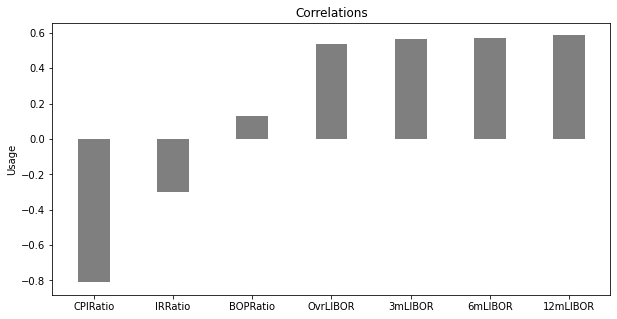

In [20]:
y_pos = np.arange(0,14,2)
plt.figure(figsize=(10,5))
plt.bar(y_pos, correlations, align='center', alpha=0.5, color=(0.0, 0.0, 0.0, 1))
plt.xticks(y_pos, variables)
plt.ylabel('Usage')
plt.title('Correlations')

plt.show()

# Neural Networks

## Data setup

In [0]:
import math

EPOCHS = 1
EVALUATION_INTERVAL = 100
VALIDATION_STEPS = 50
BATCH_SIZE = 30
FOLDS = 5

HISTORY_STEPS = 20
FUTURE_STEPS = 3

features = ['ForexRate']

dataSet = completeDf[features]
dataSet = dataSet.values

fold_steps = math.floor(len(dataSet) / FOLDS)
fold_locations = []
results = []

for x in range(0,len(dataSet), fold_steps):
    fold_locations.append(x)

## Data splitting functions

In [0]:
def getIndices(currentIndex, steps):

    indices = []

    index = currentIndex

    for i in range(1, steps + 1):
        if i % 4 == 0:
            indices.append(index)
            index = index - 21
        else:
            indices.append(index)
            index = index - 22

    indices = list(reversed(indices))

    return indices


def singleStepDataSplit(dataset, target, startIndex, endIndex,
                steps, future_steps):  
    data = []
    labels = []

    history_size = 22 * steps

    max_index = 22 * future_steps
    target_size = round(21.75 * future_steps)

    startIndex = startIndex + history_size

    if endIndex is None:
        endIndex = len(dataset) - max_index

    for i in range(startIndex, endIndex):
        dataIndices = getIndices(i,steps)
        data.append(dataset[dataIndices])
        labels.append(target[i+target_size])

    return np.array(data), np.array(labels)

def getFutureIndices(currentIndex, steps):

    indices = []

    index = currentIndex + 22

    for i in range(1, steps + 1):
        if i % 4 == 0:
            indices.append(index)
            index = index + 21
        else:
            indices.append(index)
            index = index + 22

    return indices


def splitData(dataset, target, start_index, end_index, steps, future_steps):
    data = []
    labels = []

    history_size = 22 * steps
    target_size = 22 * future_steps

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = getIndices(i,steps)
        data.append(dataset[indices])
        indiciesL = getFutureIndices(i, future_steps)
        labels.append(target[indiciesL])


    return np.array(data), np.array(labels)

## Single-step LSTM

### Building network

In [0]:
def singleStepLSTM():
    singleStepLSTMModel = keras.Sequential([
        layers.LSTM(32, input_shape=(HISTORY_STEPS, len(features))),
        layers.Dense(1)
    ])

    singleStepLSTMModel.compile(optimizer='adam', loss='mse')
    return singleStepLSTMModel

### Training models

In [27]:
dataVal = []

def trainModel(history_steps, future_step):

    models = []
    results = []

    for x in range(1, FOLDS):

        model = singleStepLSTM()

        valIndex = fold_locations[x]
        
        if (x==FOLDS-1):
            endIndex = None
        else:
            endIndex = fold_locations[x+1]

        xTrain, yTrain = singleStepDataSplit(dataSet, dataSet[:, 0], 0, valIndex, history_steps, future_step)
        xVal, yVal = singleStepDataSplit(dataSet, dataSet[:, 0], valIndex, endIndex, history_steps, future_step)

        dataTrain = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
        dataTrain = dataTrain.cache().batch(BATCH_SIZE).repeat()

        dataVal = tf.data.Dataset.from_tensor_slices((xVal, yVal))
        dataVal = dataVal.batch(BATCH_SIZE).repeat()

        print("--------------------- Model validated on fold ", "%d/%d --------------------------" % (x, FOLDS - 1))

        result = model.fit(dataTrain, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                            validation_data=dataVal, validation_steps=50)
        
        models.append(model)
        results.append(result)

    return models


def createModelsForAllSteps():

    for i in range(1,FUTURE_STEPS+1):

        print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&& Month", "%d/%d &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&" % (i, FUTURE_STEPS))

        models = trainModel(HISTORY_STEPS, i)
        allModels.append(models)


    return allModels

allModels = createModelsForAllSteps()

&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&& Month 1/3 &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
--------------------- Model validated on fold  1/4 --------------------------
100/100 [==============================] - 1s 14ms/step - loss: 0.1573 - val_loss: 0.1675
--------------------- Model validated on fold  2/4 --------------------------
100/100 [==============================] - 1s 15ms/step - loss: 0.2768 - val_loss: 0.3894
--------------------- Model validated on fold  3/4 --------------------------
100/100 [==============================] - 1s 14ms/step - loss: 0.4264 - val_loss: 0.2383
--------------------- Model validated on fold  4/4 --------------------------
100/100 [==============================] - 1s 14ms/step - loss: 0.3627 - val_loss: 0.0265
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&& Month 2/3 &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
--------------------- Model validated on fold  1/4 --------------------------
100/100 [==============================] - 1s 14ms/step - loss: 0.1564 - val_loss: 0.2692
----

### Single-step tests

In [36]:
allMses = []
allClassifications = []
bestGuessClassifications = []
relaxedGuessClassifications = []

def singleStepModelTests(model, xTest, yTest):

    mses = []
    classifications = []

    correctDirection = 0

    noDatapoints = len(xTest)
    print(noDatapoints)

    noPredictions = 6

    mse = model.evaluate(xTest,yTest)

    for x in range(noDatapoints):
        current = xTest[x][-1]
        past = tf.constant([xTest[x]])
        prediction = model.predict(past)[0]
        future = yTest[x]

        if((current > prediction) == (current > future)):
                correctDirection = correctDirection + 1

    #print("-------------------------------")
    #print("MSE: " + str(round(mse,3)))
    directionClass = correctDirection / noDatapoints
    #print("Direction classification: " + str(round(directionClass,3)))
    #print("-------------------------------")

    mses.append(mse)
    classifications.append(directionClass)

    return mses, classifications


def runModels(models):

    modelMses = []
    modelClassifications = []

    for i in range(1, FOLDS):

        print("running test")

        valIndex = fold_locations[i]
    
        if (i==FOLDS-1):
            endIndex = None
        else:
            endIndex = fold_locations[i+1]

        xTest, yTest = singleStepDataSplit(dataSet, dataSet[:, 0], valIndex, endIndex, HISTORY_STEPS, FUTURE_STEPS)

        mses,classifications = singleStepModelTests(models[i-1], xTest, yTest)

        modelMses.append(mses)
        modelClassifications.append(classifications)

        meanMse = np.mean(modelMses)
        meanClass = np.mean(modelClassifications)
    
    #print("-------------------------------------------------------------")
    #print("Average MSE: " + str(meanMse))
    #print("Average classification: " + str(np.mean(classifications)))
    #print("-------------------------------------------------------------")

    return modelMses, modelClassifications


def bestGuessTests(models):

    valIndex = fold_locations[FOLDS-1]
    endIndex = None
    correctMax = 0
    correctMaxRelaxed = 0

    xTest, yTest = splitData(dataSet, dataSet[:, 0], valIndex, endIndex, HISTORY_STEPS, FUTURE_STEPS)

    for datapoint in range(len(xTest)):

        past = tf.constant([xTest[datapoint]])
        future = yTest[datapoint]

        predictions = []

        for j in range(FUTURE_STEPS):

            prediction = models[j].predict(past)
            predictions.append(prediction)

        actualMax = np.argmax(future)
        predictedMax = np.argmax(predictions)

        futureRemovingMax = np.delete(future, actualMax)
        actual2ndMax = np.argmax(futureRemovingMax)

        if(predictedMax == actualMax):
            correctMax = correctMax + 1
            correctMaxRelaxed = correctMaxRelaxed + 1
        elif(predictedMax == actual2ndMax):
            correctMaxRelaxed = correctMaxRelaxed + 1

    #print("---------------")
    bestMonthClass = correctMax / len(xTest)
    bestMonthRelaxedClass = correctMaxRelaxed / len(xTest)

    #print("Correct best month: " + str(round(bestMonthClass,3)))

    return bestMonthClass, bestMonthRelaxedClass

def runBestGuessTests(allModels):

    foldPerformances = []
    relaxedFoldperformances = []

    for i in range(len(allModels[0])):

        print("running best guess test")

        foldModels = []

        for j in range(FUTURE_STEPS):
            foldModels.append(allModels[j][i])

        foldPerformance, relaxedFoldperformance = bestGuessTests(foldModels)

        foldPerformances.append(foldPerformance)
        relaxedFoldperformances.append(relaxedFoldperformance)

    return foldPerformances, relaxedFoldperformances


def singleStepExperiments():
    
    print("MODELS CREATED")

    for modelsForOneStep in allModels:
        print("MODEL STEP TESTS")

        modelMses, modelClassifications = runModels(modelsForOneStep)
        allMses.append(modelMses)
        allClassifications.append(modelClassifications)

    print("MODEL STEP TESTS COMPLETE")
    print("TESTING BEST GUESS ABILITY")

    bestGuessClassifications, relaxedGuessClassifications = runBestGuessTests(allModels)

    #bestGuessClassifications.append(bestGuess)
    #relaxedGuessClassifications.append(relaxedGuess)

    print(bestGuessClassifications)
    print(relaxedGuessClassifications)

    print("TESTING COMPLETE")

singleStepExperiments()

print(bestGuessClassifications) 


MODELS CREATED
MODEL STEP TESTS
running test
507
16/16 [==============================] - 0s 3ms/step - loss: 0.2821
running test
507
16/16 [==============================] - 0s 3ms/step - loss: 0.3548
running test
507
16/16 [==============================] - 0s 3ms/step - loss: 0.3477
running test
445
14/14 [==============================] - 0s 3ms/step - loss: 0.0272
MODEL STEP TESTS
running test
507
16/16 [==============================] - 0s 3ms/step - loss: 0.3391
running test
507
16/16 [==============================] - 0s 3ms/step - loss: 0.1927
running test
507
16/16 [==============================] - 0s 3ms/step - loss: 0.2395
running test
445
14/14 [==============================] - 0s 3ms/step - loss: 0.0419
MODEL STEP TESTS
running test
507
16/16 [==============================] - 0s 3ms/step - loss: 0.3723
running test
507
16/16 [==============================] - 0s 3ms/step - loss: 0.4548
running test
507
16/16 [==============================] - 0s 3ms/step - loss: 0.2552

In [39]:
print(allMses)                      #shape = FUTURE_STEPS, FOLDS
print(allClassifications)           #shape = FUTURE_STEPS, FOLDS
print(bestGuessClassifications)      #shape = FOLDS
print(relaxedGuessClassifications)   #shape = FOLDS

[[[0.28208333253860474], [0.35479700565338135], [0.3477408289909363], [0.027156421914696693]], [[0.3391296863555908], [0.19265110790729523], [0.2394864857196808], [0.04186803475022316]], [[0.3722698986530304], [0.4547564387321472], [0.25516942143440247], [0.04531000927090645]]]
[[[0.32741617357001973], [0.6587771203155819], [0.21893491124260356], [0.6876404494382022]], [[0.33925049309664695], [0.6587771203155819], [0.21893491124260356], [0.6449438202247191]], [[0.3333333333333333], [0.6587771203155819], [0.21893491124260356], [0.6134831460674157]]]
[[0.3842696629213483, 0.37303370786516854, 0.21123595505617979, 0.29213483146067415]]
[[0.5955056179775281, 0.37303370786516854, 0.5101123595505618, 0.3842696629213483]]


In [74]:
print(allMses[0])

[[0.28208333253860474], [0.35479700565338135], [0.3477408289909363], [0.027156421914696693]]


### Results

In [0]:
def printResults(mses,directionClass,bestClass):

    for i in range(FUTURE_STEPS):

        print("-----------")
        print("Month " + str((i+1)))
        print("MSE: " + str(mses[i]))
        print("Dir: " + str(directionClass[i]))

    print("---------")
    print("Bes: " + str(bestClass))

printResults(allMses, allClassifications, bestClass)

### Prediction visualisation

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def create_time_steps(length,steps):
    return list(np.arange(-length, 0,step=steps))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(TIME_LAGS,STEP)

    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                    label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt


for x, y in dataVal.take(1):
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                        model.predict(x)[0]], PREDICTION_HORIZON,
                    'Single Step Prediction')
    print(model.predict(x)[0])
    plot.show()

## Multi-step LSTM

### Building network

In [0]:
def multiStepLSTM():
    multiStepLSTMModel = keras.Sequential([
        layers.LSTM(units=32, return_sequences=True, input_shape = (HISTORY_STEPS, len(features))),
        layers.LSTM(16, activation='relu'),
        layers.Dense(FUTURE_STEPS)
    ])

    multiStepLSTMModel.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')
    return multiStepLSTMModel

multiStepModel = multiStepLSTM()

### Training models

In [56]:
models = []
results = []
dataTrainMulti = []

for x in range(1, FOLDS):

    valIndex = fold_locations[x]

    multiStepModel = multiStepLSTM()
    
    if (x==FOLDS-1):
        endIndex = None
    else:
        endIndex = fold_locations[x+1]

    xTrainMulti, yTrainMulti = splitData(dataSet, dataSet[:, 0], 0, valIndex, HISTORY_STEPS, FUTURE_STEPS)
    xValMulti, yValMulti = splitData(dataSet, dataSet[:, 0], valIndex, None, HISTORY_STEPS, FUTURE_STEPS)

    dataTrainMulti = tf.data.Dataset.from_tensor_slices((xTrainMulti, yTrainMulti))
    dataTrainMulti = dataTrainMulti.cache().batch(BATCH_SIZE).repeat()

    dataValMulti = tf.data.Dataset.from_tensor_slices((xValMulti, yValMulti))
    dataValMulti = dataValMulti.batch(BATCH_SIZE).repeat()

    print("--------------------- Model", "%d/%d --------------------------" % (x, FOLDS - 1))

    result = multiStepModel.fit(dataTrainMulti, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                        validation_data=dataValMulti, validation_steps=50)
    
    models.append(multiStepModel)
    results.append(result)

--------------------- Model 1/4 --------------------------
100/100 [==============================] - 2s 22ms/step - loss: 0.1267 - val_loss: 0.9395
--------------------- Model 2/4 --------------------------
100/100 [==============================] - 2s 22ms/step - loss: 0.1384 - val_loss: 0.4291
--------------------- Model 3/4 --------------------------
100/100 [==============================] - 2s 23ms/step - loss: 0.6042 - val_loss: 0.3162
--------------------- Model 4/4 --------------------------
100/100 [==============================] - 2s 22ms/step - loss: 0.2574 - val_loss: 0.3167


### Multi-step tests

In [0]:
allMsesMulti = []
allClassificationsMulti = []
bestGuessClassificationsMulti = []
relaxedGuessClassificationsMulti = []

def multiStepModelTests(model, xTest, yTest):

    correctDirection = [0,0,0]
    totalSquaredError = [0,0,0]
    correctMax = 0
    correctMaxRelaxed = 0

    noDatapoints = len(xTest)
    noPredictions = len(totalSquaredError)

    for x in range(noDatapoints):
        current = xTest[x][-1]
        past = tf.constant([xTest[x]])
        predictions = model.predict(past)[0]
        future = yTest[x]

        predictedMax = np.argmax(predictions)
        actualMax = np.argmax(future)

        futureRemovingMax = np.delete(future, actualMax)
        actual2ndMax = np.argmax(futureRemovingMax)

        if(predictedMax == actualMax):
            correctMax = correctMax + 1
            correctMaxRelaxed = correctMaxRelaxed + 1
        elif(predictedMax == actual2ndMax):
            correctMaxRelaxed = correctMaxRelaxed + 1

        for y in range(noPredictions):
            prediction = predictions[y]
            actual = future[y]

            squaredDifference = abs(prediction - actual) ** 2
            totalSquaredError[y] = totalSquaredError[y] + squaredDifference

            if ((current > prediction) == (current > actual)):
                correctDirection[y] = correctDirection[y] + 1

    mses = []
    classifications = []


    #print("---------------")
    for x in range(noPredictions):
        mse = totalSquaredError[x] / noDatapoints
        mses.append(mse)
        #print("MSE (Month " + str(x+1) + "): " + str(round(mse,3)))

    averageMSE = (sum(totalSquaredError) / noDatapoints) / noPredictions
    #print("Average MSE: " + str(round(averageMSE,3)))


    #print("---------------")
    for x in range(noPredictions):
        percentInterval = correctDirection[x] / noDatapoints
        classifications.append(percentInterval)
        #print("Direction (Month " + str(x+1) + "): " + str(round(percentInterval,3)))

    directionClass = (sum(correctDirection) / noDatapoints) / noPredictions
    #print("Average classification: " + str(round(directionClass,3)))

    bestMonthClass = correctMax / noDatapoints
    bestMonthRelaxedClass = correctMaxRelaxed / noDatapoints

    allMsesMulti.append(mses)
    allClassificationsMulti.append(classifications)
    bestGuessClassificationsMulti.append(bestMonthClass)
    relaxedGuessClassificationsMulti.append(bestMonthRelaxedClass)

    #return mses, classifications


def runModels(models):

    modelMses = []
    modelClassifications = []

    for i in range(1, FOLDS):

        valIndex = fold_locations[i]
    
        if (i==FOLDS-1):
            endIndex = None
        else:
            endIndex = fold_locations[i+1]

        xTestMulti, yTestMulti = splitData(dataSet, dataSet[:, 0], valIndex, endIndex, HISTORY_STEPS, FUTURE_STEPS)

        multiStepModelTests(models[i-1], xTestMulti, yTestMulti)

        #modelMses.append(mses)
        #modelClassifications.append(classifications)

    #monthAverageMses = []
    #monthAverageClass = []

    #for i in range(FUTURE_STEPS):

    #    totalMse = 0
    #    totalClass = 0

    #    for j in range(len(modelMses)):
    #        totalMse = totalMse + modelMses[j][i]
    #        totalClass = totalClass + modelClassifications[j][i]

    #    meanMse = totalMse / len(modelMses)
    #    meanClass = totalClass / len(modelMses)

    #    monthAverageMses.append(meanMse)
    #    monthAverageClass.append(meanClass)

    #print("-------------------------------------------------------------")
    #print("Average MSE: " + str(meanMse))
    #print("Average classification: " + str(np.mean(classifications)))
    #print("-------------------------------------------------------------")

    #return monthAverageMses, monthAverageClass

runModels(models)

In [64]:
allMsesMulti = list(map(list, zip(*allMsesMulti)))
allClassificationsMulti = list(map(list, zip(*allClassificationsMulti)))

print(allMsesMulti)
print(allClassificationsMulti)
print(bestGuessClassificationsMulti)
print(relaxedGuessClassificationsMulti)

[[0.368149258477947, 0.7458649629555281, 0.18965386960754538, 0.17624082139322075], [0.5418028138295523, 0.7402328365651868, 0.21322863096489184, 0.20829377411543798], [0.4679014906467884, 0.6405907022683212, 0.20986167706327624, 0.5573958810242827]]
[[0.40433925049309666, 0.6074950690335306, 0.45956607495069035, 0.4764044943820225], [0.45759368836291914, 0.6094674556213018, 0.3905325443786982, 0.5438202247191011], [0.3530571992110454, 0.6587771203155819, 0.46745562130177515, 0.5797752808988764]]
[0.1992110453648915, 0.22879684418145957, 0.6193293885601578, 0.37303370786516854]
[0.47731755424063116, 0.7120315581854043, 0.6232741617357002, 0.37303370786516854]


### Results

In [0]:
def printResults(monthAverageMses,monthAverageClass,bestClass):

    for i in range(len(monthAverageMses)):

        print("-----------")
        print("Month " + str((i+1)))
        print("MSE: " + str(monthAverageMses[i]))
        print("Dir: " + str(monthAverageClass[i]))

    print("---------")
    print("Bes: " + str(bestClass))

printResults(monthAverageMses, monthAverageClass, bestClass)

### Prediction visualisation

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(TIME_LAGS,STEP)
  num_out = len(true_future) * FUTURE_STEP

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out, step=FUTURE_STEP), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out,step=FUTURE_STEP), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

model = models[-1]

for x, y in dataTrainMulti.take(1):

    print(x)

    #print((multiStepModel.predict(x)[0]).index(max(multiStepModel.predict(x)[0])))
    print(model.predict(x)[0])
    multi_step_plot(x[0], y[0], model.predict(x)[0])


# Exporting Results

In [99]:
!pip install --upgrade -q pygsheets

import google.auth
from google.colab import auth

auth.authenticate_user()
import pygsheets
credentials, _ = google.auth.default()
gc = pygsheets.client.Client(credentials)

gc.create(title="TestResults01",folder="1zb8cLLf2RtYz9RuofDhGDgmTAoXD2VnE")

sh = gc.open('TestResults01')

sh.add_worksheet('test2',rows=5, cols=20) 

wk1 = sh[0]

titles = ['SINGLE_STEP','MSE(Fold1)','MSE(Fold2)','MSE(Fold3)','MSE(Fold4)','MSE(avg)',
          'Dir(Fold1)','Dir(Fold2)','Dir(Fold3)','Dir(Fold4)','Dir(avg)']

shiftSize = FUTURE_STEPS+5

wk1.insert_rows(row = 1, number = 0, values = titles) # insert 1 new row and insert values in same row

mseAvgs = []
dirAvgs = []

for step in range(FUTURE_STEPS):

    row = []

    month = 'Month ' + str(step+1)

    row.append(month)
    
    for fold in range(FOLDS-1):
        row.append(str(allMses[step][fold][0]))

    arr = np.asarray(allMses[step])
    mean = np.mean(arr)
    row.append(mean)
    mseAvgs.append(mean)

    for fold in range(FOLDS-1):
        row.append(str(allClassifications[step][fold][0]))

    arr = np.asarray(allClassifications[step])
    mean = np.mean(arr)
    row.append(str(mean))
    dirAvgs.append(mean)

    wk1.insert_rows(row = step+1, number = 1, values = row)


titles[0] = 'MULTI-STEP'

wk1.insert_rows(row = shiftSize, number = 0, values = titles) # insert 1 new row and insert values in same row

for step in range(FUTURE_STEPS):

    row = []

    month = 'Month ' + str(step+1)

    row.append(month)
    
    for fold in range(FOLDS-1):
        row.append(str(allMsesMulti[step][fold]))

    arr = np.asarray(allMsesMulti[step])
    mean = np.mean(arr)
    row.append(mean)
    mseAvgs.append(mean)

    for fold in range(FOLDS-1):
        row.append(str(allClassificationsMulti[step][fold]))

    arr = np.asarray(allClassificationsMulti[step])
    mean = np.mean(arr)
    row.append(str(mean))
    dirAvgs.append(mean)

    print(row)

    wk1.insert_rows(row = shiftSize+step+2, number = 1, values = row)







['Month 1', '0.368149258477947', '0.7458649629555281', '0.18965386960754538', '0.17624082139322075', 0.3699772281085603, '0.40433925049309666', '0.6074950690335306', '0.45956607495069035', '0.4764044943820225', '0.486951222214835']
['Month 2', '0.5418028138295523', '0.7402328365651868', '0.21322863096489184', '0.20829377411543798', 0.4258895138687672, '0.45759368836291914', '0.6094674556213018', '0.3905325443786982', '0.5438202247191011', '0.500353478270505']
['Month 3', '0.4679014906467884', '0.6405907022683212', '0.20986167706327624', '0.5573958810242827', 0.4689374377506671, '0.3530571992110454', '0.6587771203155819', '0.46745562130177515', '0.5797752808988764', '0.5147663054318197']


In [95]:
print(allMsesMulti[0][0])

0.368149258477947
